In [1]:
import yaml
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy.interpolate import RegularGridInterpolator

In [2]:
with open('data_unequal_grid.yml', 'r') as file:
    data = yaml.load(file)
    
x_reference = data['x_mephisto']
y_reference = data['d_mephisto']
dose_reference = data['mephisto_dose_grid']

x_evaluation = data['x_monaco']
y_evaluation = data['d_monaco']
dose_evaluation = data['monaco_dose_grid']

coords_reference = (y_reference, x_reference)
coords_evaluation = (y_evaluation, x_evaluation)

In [3]:
reference_interpolation = RegularGridInterpolator(
    coords_reference, dose_reference
)

In [4]:
distance_threshold = 2
distance_step_size = distance_threshold / 10

dose_threshold = 0.02 * np.max(dose_evaluation)

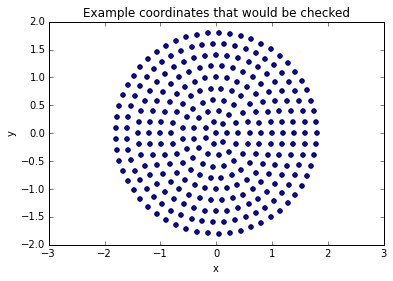

In [5]:
def coords_to_check_2d(distance, step_size):
    amount_to_check = np.floor(
        2 * np.pi * distance / step_size) + 1
    theta = np.linspace(0, 2*np.pi, amount_to_check + 1)[:-1:]
    x = distance * np.cos(theta)
    y = distance * np.sin(theta)
    
    return x, y

for distance in np.arange(0, 2, 0.2):
    x, y = coords_to_check_2d(distance, distance_step_size)
    plt.scatter(x, y)

plt.axis("equal")

plt.title('Example coordinates that would be checked')
plt.xlabel('x')
plt.ylabel('y')

In [7]:
y, x = coords_evaluation
xx, yy = np.meshgrid(x, y)
dose_evaluation = np.array(dose_evaluation)

lower_dose_cutoff = np.max(dose_evaluation) * 0.2
dose_valid = dose_evaluation > lower_dose_cutoff
gamma_valid = np.ones_like(dose_evaluation).astype(bool)

running_gamma = np.inf * np.ones_like(dose_evaluation)

distance = 0

In [8]:
def find_min_dose_difference_at_distance_2d(x_test, y_test, dose_test, 
                                            distance, step_size):
    x_shift, y_shift = coords_to_check_2d(
        distance, step_size)

    x_coords = x_test[None,:] + x_shift[:, None]
    y_coords = y_test[None,:] + y_shift[:, None]
    
    all_points = np.concatenate(
        (y_coords[:,:,None], x_coords[:,:,None]), axis=2)
    
    dose_difference = np.array([
        reference_interpolation(points) - dose_test for 
        points in all_points
    ])
    min_dose_difference = np.min(np.abs(dose_difference), axis=0)
    
    return min_dose_difference


while True:
    x_valid = (
        (xx > np.min(x_reference) + distance) &
        (xx < np.max(x_reference) - distance))

    y_valid = (
        (yy > np.min(y_reference) + distance) &
        (yy < np.max(y_reference) - distance))

    to_be_checked = (
        dose_valid & x_valid & y_valid & gamma_valid
    )

    min_dose_diff = find_min_dose_difference_at_distance_2d(
        xx[to_be_checked], yy[to_be_checked], 
        dose_evaluation[to_be_checked], 
        distance, distance_step_size)

    gamma_at_distance = np.sqrt(
        min_dose_diff ** 2 / dose_threshold ** 2 + 
        distance **2 / distance_threshold **2)

    running_gamma[to_be_checked] = np.min(
        np.vstack((
                gamma_at_distance, running_gamma[to_be_checked]
            )), axis=0)

    gamma_valid = running_gamma > distance / distance_threshold

    distance += distance_step_size
    
    if np.sum(to_be_checked) == 0:
        break

In [9]:
gamma = running_gamma[~np.isinf(running_gamma)]

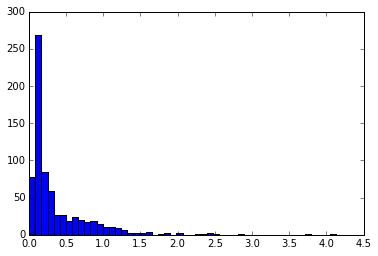

In [10]:
plt.hist(gamma, 50);

In [13]:
np.sum(gamma <= 1) / len(gamma)

0.92167832167832164

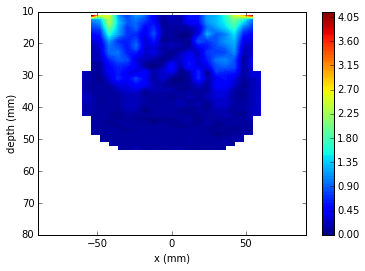

In [11]:
plt.contourf(x_evaluation, y_evaluation, running_gamma, 100)
plt.gca().invert_yaxis()
plt.colorbar()
plt.xlabel('x (mm)')
plt.ylabel('depth (mm)')